In [25]:
import tensorflow as tf
import pandas as pd
import os
from keras.initializers import glorot_normal
import keras
import time
import pickle
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
import numpy.random as rng
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
import matplotlib
import math
import numpy as np
import math
import h5py
import string
from tensorflow.python.framework import ops
import string

In [2]:
df = pd.read_csv('./training.csv')
df1 = pd.read_csv('./test.csv')

In [3]:
df = df.dropna()
df1 = df1.dropna()
df.iloc[30,:]

left_eye_center_x                                                      64.1556
left_eye_center_y                                                      35.2538
right_eye_center_x                                                     30.7579
right_eye_center_y                                                     35.2538
left_eye_inner_corner_x                                                57.2384
left_eye_inner_corner_y                                                36.1483
left_eye_outer_corner_x                                                71.9195
left_eye_outer_corner_y                                                35.9552
right_eye_inner_corner_x                                               37.5205
right_eye_inner_corner_y                                               36.1742
right_eye_outer_corner_x                                               23.8218
right_eye_outer_corner_y                                               37.0526
left_eyebrow_inner_end_x                            

In [5]:
def load_img_data():
    images = np.zeros([len(df.Image),96,96])
    for index,strimg in enumerate(df.Image) :
        img=np.zeros([96,96])
        test=np.fromstring(strimg, dtype=int, sep=' ')
        i=0
        j=0
        for items in range(0,len(test)):
            img[i,:] = test[j:j+96]
            if (items+1)%96==0:
                i=i+1
                j=items+1
        images[index,:,:]  = img/255       
    print(np.shape(images))
    return images

In [10]:
# images.dump("./Test_Images.pkl")

In [6]:
with open(os.path.join("./Training_Images.pkl"), "rb") as f:
    (images) = pickle.load(f)
with open(os.path.join("./Test_Images.pkl"), "rb") as f:
    (images_test) = pickle.load(f)      

In [7]:
X=np.asarray(df.iloc[:,0:-1])
print(np.shape(X))


(2140, 30)


In [12]:
# Image.dump("./Training_Images.pkl")

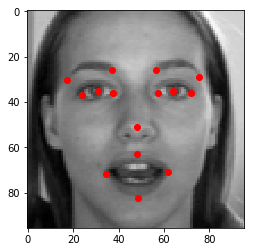

In [8]:
plt.imshow(images[30], cmap=plt.cm.gray)
plt.plot([X[30,::2]],[X[30,1::2]],'ro')
plt.show()


In [11]:
flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]
flip_indices=np.array(flip_indices)
X_reversed = np.copy(X)
for index in flip_indices:
    Temp = np.copy(X_reversed[:,index[0]])
    X_reversed[:,index[0]] = X_reversed[:,index[1]]
    X_reversed[:,index[1]] = Temp
print np.shape(X_reversed)


(2140, 30)


In [12]:
def flip_images():
    images_rev = images[:,:,::-1]
    Image = np.concatenate((images,images_rev),axis=0)
    return Image
X_feat = np.concatenate((X,X_reversed),axis=0)
np.shape(X_feat)


(4280, 30)

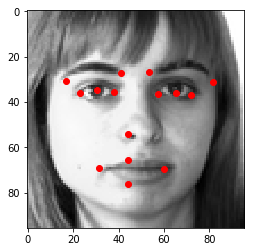

In [16]:
Image = images
plt.imshow(Image[3660], cmap=plt.cm.gray)
plt.plot([X_feat[3660,::2]],[X_feat[3660,1::2]],'ro')
plt.show()


In [17]:
images_train , images_cv, Y_train, Y_cv = train_test_split(Image, X_feat, train_size=0.92, random_state=42)


/home/vishwesh/anaconda3/envs/tensorflow/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [26]:
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (96,96,1)

model = Sequential()
model.add(Conv2D(32,(4,4),activation='relu',input_shape=input_shape,kernel_initializer=glorot_normal(seed=None),kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Dropout(0.1))
model.add(Conv2D(64,(3,3),activation='relu',kernel_initializer=glorot_normal(seed=None),kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(128,(2,2),activation='relu',kernel_initializer=glorot_normal(seed=None),kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
# model.add(Dropout(0.3))
model.add(Conv2D(256,(1,1),activation='relu',kernel_initializer=glorot_normal(seed=None),kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
# model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(1000,activation="relu",kernel_regularizer=l2(1e-3),kernel_initializer=glorot_normal(seed=None),bias_initializer=b_init))
# model.add(Dropout(0.5))
model.add(Dense(1000,activation="relu",kernel_regularizer=l2(1e-3),kernel_initializer=glorot_normal(seed=None),bias_initializer=b_init))
# model.add(Dropout(0.6))
model.add(Dense(30,activation=None,kernel_regularizer=l2(1e-3),kernel_initializer=glorot_normal(seed=None),bias_initializer=b_init))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 93, 93, 32)        544       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 128)       32896     
__________

In [71]:
model.load_weights('./Training_featext.h5')

In [79]:
m_train,h,w=images_train.shape
m_cv,h,w = images_cv.shape
model.compile(loss=keras.losses.mean_squared_error,optimizer= Adam(0.0001),metrics=['accuracy'])
model.fit(images_train.reshape(m_train,h,w,1),Y_train,batch_size=128,epochs=1000,verbose=1,validation_data=(images_cv.reshape(m_cv,h,w,1) , Y_cv))

Train on 3937 samples, validate on 343 samples
Epoch 1/1000
3937/3937 [==============================] - 167s 42ms/step - loss: 1.0279 - acc: 0.9500 - val_loss: 64.0637 - val_acc: 0.7930
Epoch 2/1000
 384/3937 [=>............................] - ETA: 2:41 - loss: 0.8626 - acc: 0.9792

KeyboardInterrupt: 

In [39]:
# model.save("./Training_featext.h5")

In [63]:
y_predicted_train=model.predict(images_train.reshape(m_train,h,w,1))
y_predicted_cv = model.predict(images_cv.reshape(m_cv,h,w,1))

Training Image blue:true points, red:Predicted points


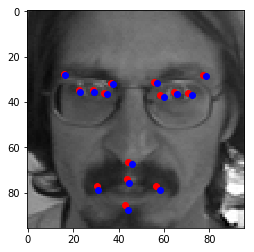

In [78]:
img_no = 898
print("Training Image blue:true points, red:Predicted points")
plt.imshow(images_train[img_no], cmap=plt.cm.gray)
plt.plot([y_predicted_train[img_no,::2]],[y_predicted_train[img_no,1::2]],'ro')
plt.plot([Y_train[img_no,::2]],[Y_train[img_no,1::2]],'bo')
plt.show()

Cross Validation Image blue:true points, red:Predicted points


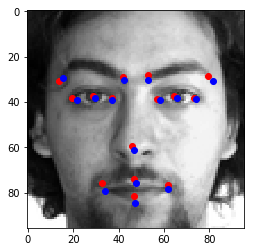

In [76]:
img_no = 21
print("Cross Validation Image blue:true points, red:Predicted points")
plt.imshow(images_cv[img_no], cmap=plt.cm.gray)
plt.plot([y_predicted_cv[img_no,::2]],[y_predicted_cv[img_no,1::2]],'ro')
plt.plot([Y_cv[img_no,::2]],[Y_cv[img_no,1::2]],'bo')
plt.show()